# Portfolio Optimization - qaoa solution

## Import

In [40]:
from qiskit_finance.data_providers import RandomDataProvider
import datetime
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms import QAOA
from qiskit_aer.primitives import Sampler
from qiskit.result import QuasiDistribution
from qiskit_algorithms.utils import algorithm_globals
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.circuit import QuantumCircuit

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


from qiskit_aer.noise import NoiseModel, QuantumError, ReadoutError, pauli_error, depolarizing_error, thermal_relaxation_error
from qiskit import transpile
from qiskit_ibm_runtime.fake_provider import FakeVigoV2, FakeTorino
from qiskit_aer import AerSimulator


## Generazione dei dati

In questa sezione, utilizziamo la classe `RandomDataProvider` di Qiskit per generare dati storici casuali relativi a un portafoglio di 8 asset fittizi. 

- **assets:** Numero di azioni nel portafoglio.
- **seed:** Valore per garantire la riproducibilità dei dati.
- **data_provider:** Simula i ritorni medi e la matrice di covarianza per il periodo specificato.

Il vettore `mu` contiene i ritorni medi per ogni asset, mentre la matrice `sigma` rappresenta la covarianza tra i ritorni.

In [41]:
assets = 4
seed = 2024

start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2024, 1, 1)

stocks = [("TICKER_%s" % i) for i in range(assets)]
data_provider = RandomDataProvider(
    tickers=stocks,
    start=start_date,
    end=end_date,
    seed=seed,
)

data_provider.run()

## Stampa dei dati

In [42]:
stock_data = data_provider._data

# devo escludere il giorno di inizio o di fine perché non viene considerato
dates = pd.date_range(start=start_date, end=end_date, inclusive="left")

# print(dates)
print(f"\nDati Generati per il periodo dal {start_date.date()} al {end_date.date()}:")
print("-" * 80)
print(f"{'Data':<12}", end="")
for i in range(len(stock_data)):
    print(f"TICKER_{i:<5}", end="")
print()

for i, date in enumerate(dates):
    # print(i)
    # print(f"{date.date():<12}", end="")
    print(f"{date.strftime('%Y-%m-%d'):<12}", end="")
    
    # print(stock_data[i])
    for j in range(len(stock_data)):
        print(f"{stock_data[j][i]:<12.3f}", end="")
    
    print()
print("-" * 80)


Dati Generati per il periodo dal 2020-01-01 al 2024-01-01:
--------------------------------------------------------------------------------
Data        TICKER_0    TICKER_1    TICKER_2    TICKER_3    
2020-01-01  99.029      3.526       6.857       54.461      
2020-01-02  100.671     2.983       5.486       52.577      
2020-01-03  101.817     2.975       5.253       51.557      
2020-01-04  100.844     2.291       5.857       52.246      
2020-01-05  99.452      1.760       6.483       52.717      
2020-01-06  99.519      1.430       6.058       52.436      
2020-01-07  100.380     2.697       6.484       52.270      
2020-01-08  100.889     0.407       5.816       51.358      
2020-01-09  102.700     2.046       5.342       51.800      
2020-01-10  103.450     2.904       5.546       51.965      
2020-01-11  104.090     0.987       4.644       52.233      
2020-01-12  103.359     1.496       4.653       52.430      
2020-01-13  102.251     0.999       3.869       52.971      
2020-

## Visualizzazione della matrice di covarianza

Questa sezione utilizza Matplotlib per visualizzare la matrice di covarianza (`sigma`).

- Le celle più scure indicano una covarianza maggiore, cioè una correlazione più forte tra i rispettivi asset.

> Questo tipo di visualizzazione aiuta a comprendere il rischio sistematico del portafoglio.

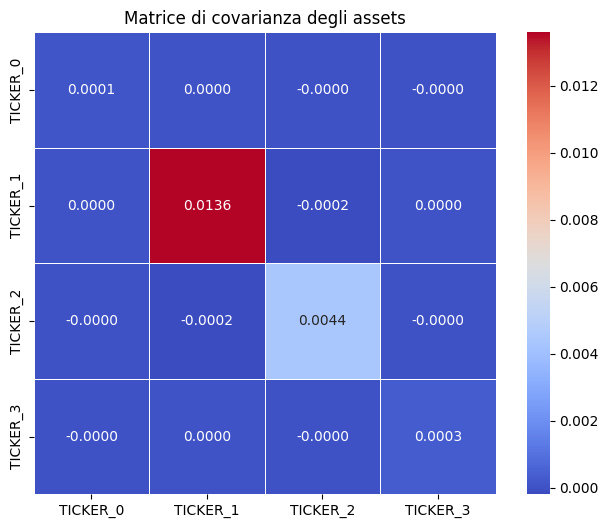

In [43]:
mu = data_provider.get_period_return_mean_vector()
sigma = data_provider.get_period_return_covariance_matrix()

sigma_df = pd.DataFrame(sigma, index=stocks, columns=stocks)

plt.figure(figsize=(8, 6))
sns.heatmap(
    sigma_df, 
    annot=True,
    fmt=".4f",
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    square=True
)
plt.title("Matrice di covarianza degli assets")
plt.show()

## Impostazione del problema di ottimizzazione

Configuriamo il problema di ottimizzazione del portafoglio utilizzando la classe `PortfolioOptimization`.

- **risk_factor:** Parametro che bilancia rischio e ritorno nell’ottimizzazione.
- **buget:** Numero massimo di asset selezionabili.

Questo problema viene convertito in un Quadratic Program, che può essere risolto sia con metodi classici che quantistici.

In [44]:
risk_factor = 0.5
# 50% of the assets
budget = assets // 2
penalty = assets

po = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=risk_factor, budget=budget
)
qp = po.to_quadratic_program()
# print(qp)

## Interpretazione dei risultati

Stampiamo e analizziamo i risultati dell'ottimizzazione:

- **Selection:** Array binario che indica quali asset sono stati inclusi nel portafoglio ottimale.
- **Value:** Valore ottimizzato del portafoglio.
- **Probabilities:** Nel caso di solver quantistici, probabilità associate agli autostati.

Questa sezione fornisce un riepilogo dettagliato delle scelte effettuate dal modello.

In [45]:

def print_result(result, portfolio):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

# QAOA

## Implementazione dell'ottimizzazione con QAOA

In questa sezione del codice, utilizziamo l'algoritmo **QAOA** (Quantum Approximate Optimization Algorithm) per risolvere il problema di ottimizzazione del portafoglio.

1. **Impostazioni iniziali:**
   - Viene impostato il seme casuale tramite `algorithm_globals.random_seed = seed` per garantire la riproducibilità dei risultati.
   
2. **Ottimizzatore COBYLA:**
   - Viene creato un ottimizzatore **COBYLA** con un massimo di 500 iterazioni. Questo ottimizzatore viene utilizzato per ottimizzare i parametri durante l'esecuzione di QAOA.

3. **Definizione del circuito QAOA:**
   - Il circuito QAOA viene creato utilizzando l'ansatz definito dal numero di ripetizioni (`reps=3`), che indica quante volte il circuito viene ripetuto per migliorare la qualità della soluzione.
   
4. **Soluzione del problema di ottimizzazione:**
   - L'algoritmo QAOA viene applicato al problema di ottimizzazione, e il risultato viene ottenuto tramite il metodo `qaoa.solve(qp)`.

In questo caso, l'ottimizzazione viene effettuata utilizzando il metodo di **MinimumEigenOptimizer**, che è una strategia per ottenere il minimo dell'Hamiltoniano associato al problema di ottimizzazione.

Infine, il risultato viene memorizzato nella variabile `result`, che conterrà le scelte ottimali di asset e il valore corrispondente.


In [46]:
algorithm_globals.random_seed = seed

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=1)
qaoa = MinimumEigenOptimizer(qaoa_mes, penalty=penalty)
result = qaoa.solve(qp)


decomposed_circuit = qaoa_mes.ansatz.decompose()
decomposed_circuit.draw("mpl")
# qaoa_mes.ansatz.draw("mpl")
print_result(result, po)

Optimal: selection [1. 0. 0. 1.], value -0.0002

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 0 1]	-0.0002		0.1299
 [0 1 0 1]	0.0051		0.1289
 [0 1 1 0]	0.0076		0.1230
 [1 1 0 0]	0.0054		0.1221
 [1 0 1 0]	0.0025		0.1191
 [0 0 1 1]	0.0023		0.1123
 [0 1 1 1]	0.0074		0.0410
 [1 0 0 0]	0.0000		0.0342
 [0 0 1 0]	0.0025		0.0332
 [1 1 1 0]	0.0077		0.0322
 [0 0 0 1]	-0.0002		0.0312
 [0 1 0 0]	0.0053		0.0303
 [1 0 1 1]	0.0023		0.0264
 [1 1 0 1]	0.0052		0.0264
 [1 1 1 1]	0.0075		0.0049
 [0 0 0 0]	0.0000		0.0049


## Simulazione del rumore

In [47]:
backend = FakeVigoV2()
# backend = FakeTorino() # 27 qubits
noise_model = NoiseModel.from_backend(backend)
simulator = AerSimulator(noise_model=noise_model)

## Stampa delle informazioni del modello

In [48]:
def print_backend_info(backend):
    print("\n=== Informazioni sul Backend ===\n")
    print(f"Nome: {backend.name}")
    print(f"Descrizione: {backend.description}")
    print(f"Versione: {backend.version}")
    print(f"Numero di Qubit: {backend.num_qubits}")
    config = backend.configuration()
    print(f"Istruzioni supportate:")
    for instruction in config.supported_instructions:
        print(f"- {instruction}")
    print()
    

def print_noise_model_info(noise_model):
    print("\n=== Informazioni sul modello di rumore ===\n")
    print(noise_model)
    # TODO aggiungere informazioni sull'errore sul singolo qubit

print_backend_info(backend)
print_noise_model_info(noise_model)


=== Informazioni sul Backend ===

Nome: fake_vigo
Descrizione: 5 qubit device Vigo
Versione: 2
Numero di Qubit: 5
Istruzioni supportate:
- cx
- id
- delay
- measure
- reset
- rz
- sx
- u1
- u2
- u3
- x


=== Informazioni sul modello di rumore ===

NoiseModel:
  Basis gates: ['cx', 'delay', 'id', 'measure', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'sx', 'cx', 'id', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('cx', (0, 1)), ('cx', (1, 0)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (2, 1)), ('cx', (3, 1)), ('cx', (3, 4)), ('cx', (4, 3)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]


## QAOA with noise

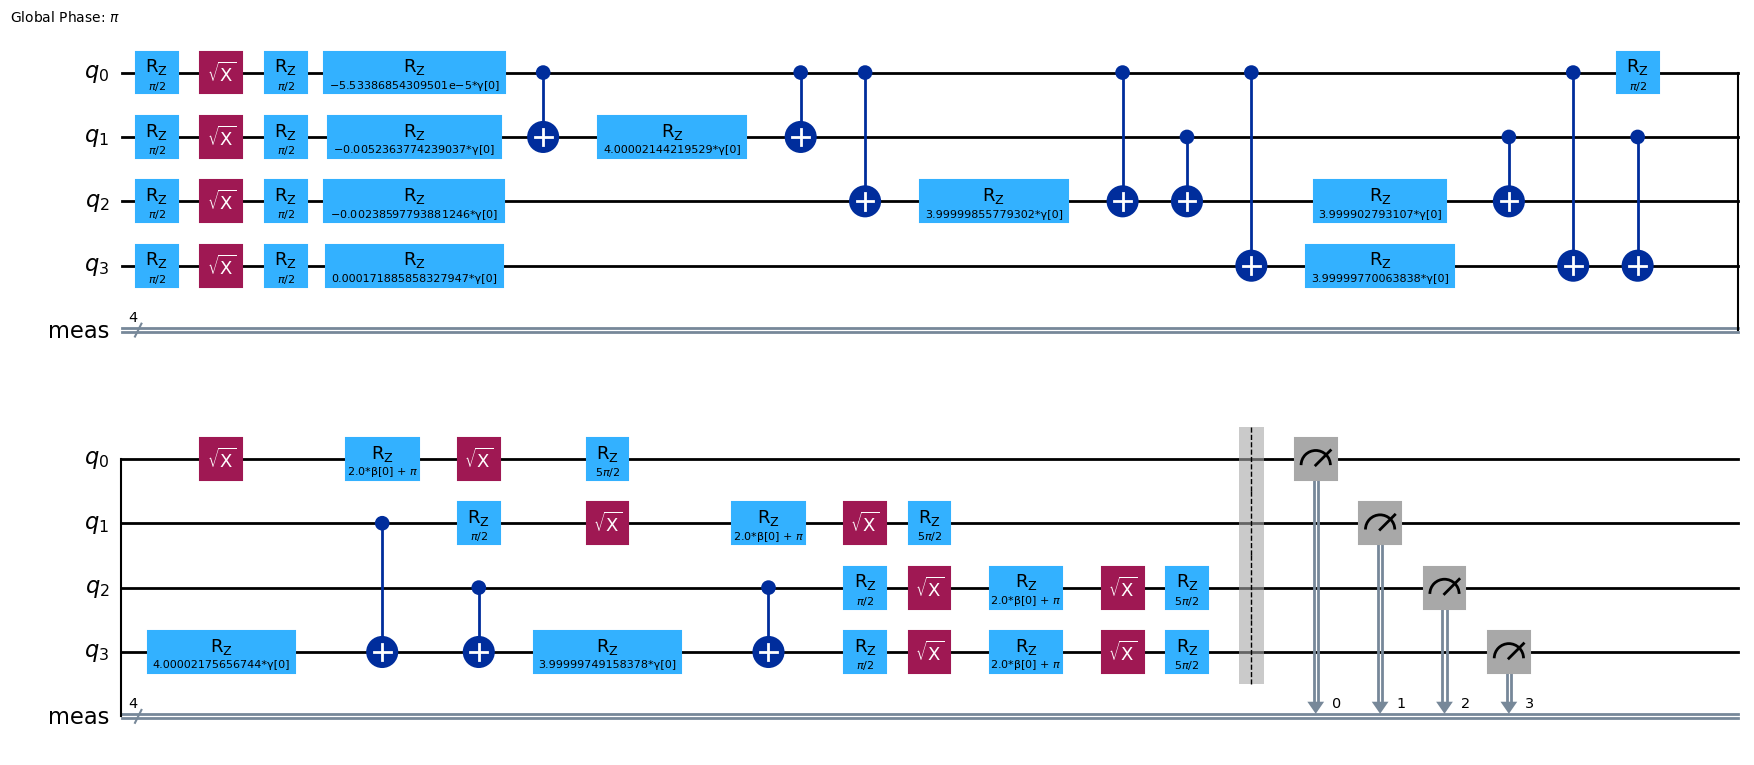

In [49]:
transpiled_circuit = transpile(decomposed_circuit, simulator)
transpiled_circuit.draw("mpl")

In [50]:
# Utilizzare il circuito decomposto come ansatz per QAOA
qaoa_mes.ansatz = decomposed_circuit

# Risolvere il problema di ottimizzazione con il nuovo ansatz
result_decomposed = qaoa.solve(qp)

# Stampare i risultati
print_result(result_decomposed, po)

Optimal: selection [1. 0. 0. 1.], value -0.0002

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 0 1]	0.0051		0.1387
 [1 1 0 0]	0.0054		0.1318
 [0 1 1 0]	0.0076		0.1270
 [1 0 1 0]	0.0025		0.1260
 [0 0 1 1]	0.0023		0.1201
 [1 0 0 1]	-0.0002		0.1201
 [0 1 1 1]	0.0074		0.0332
 [1 1 1 1]	0.0075		0.0293
 [1 1 1 0]	0.0077		0.0283
 [0 0 0 1]	-0.0002		0.0283
 [1 0 0 0]	0.0000		0.0273
 [1 1 0 1]	0.0052		0.0195
 [0 0 0 0]	0.0000		0.0186
 [1 0 1 1]	0.0023		0.0186
 [0 0 1 0]	0.0025		0.0176
 [0 1 0 0]	0.0053		0.0156


## Visualizzazione dei risultati

In questa sezione presentiamo tre diversi grafici che aiutano a interpretare e analizzare i risultati ottenuti dall'ottimizzazione del portafoglio.

1. **Grafico a barre: composizione del portafoglio ottimale**
   - Questo grafico mostra quali asset sono stati selezionati nel portafoglio ottimale, con gli asset inclusi aventi valore `1` e quelli esclusi aventi valore `0`.
   - La visualizzazione aiuta a comprendere chiaramente la distribuzione degli asset all'interno del portafoglio in base al modello ottimizzato.

2. **Grafico rischio vs ritorno atteso**
   - Il grafico mostra il valore ottimizzato del portafoglio al variare del fattore di rischio, ovvero il compromesso tra rischio e rendimento.
   - L'asse X rappresenta il fattore di rischio, mentre l'asse Y mostra il valore ottimale ottenuto, evidenziando come l'aumento del rischio impatti sul valore complessivo del portafoglio.

3. **Grafico valore ottimale vs budget**
   - In questo grafico si analizza come il valore ottimale della funzione obiettivo varia al variare del budget, cioè del numero massimo di asset selezionabili nel portafoglio.
   - L'asse X rappresenta il budget, mentre l'asse Y mostra il valore ottimale.
   - Osserviamo che con un budget maggiore, il valore ottimale tende a migliorare (essere meno negativo), ma oltre un certo punto potrebbe saturarsi, indicando che l'inclusione di ulteriori asset non porta a miglioramenti significativi.

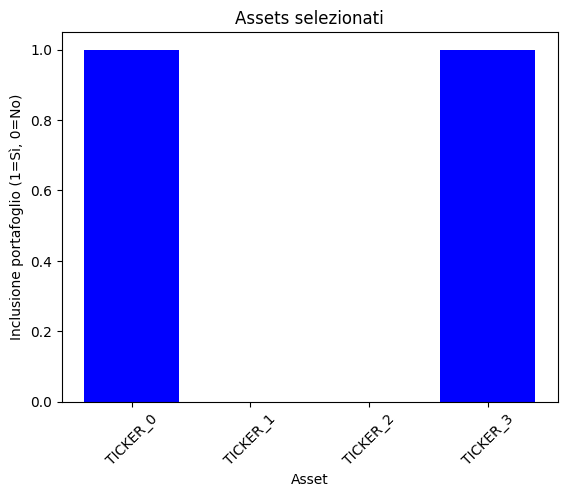

In [51]:
selection = result.x
plt.bar(stocks, selection, color='blue')
plt.title("Assets selezionati")
plt.xlabel("Asset")
plt.ylabel("Inclusione portafoglio (1=Sì, 0=No)")
plt.xticks(rotation=45)
plt.show()

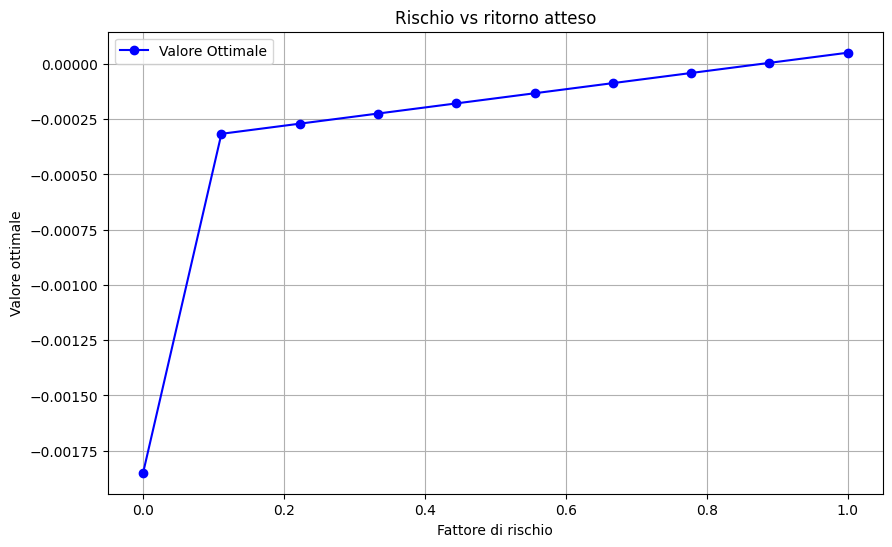

In [52]:
risks = np.linspace(0, 1, 10)
values_per_risk = []

for r in risks:
    po = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=r, budget=budget)
    qp = po.to_quadratic_program()
    
    result = qaoa.solve(qp)
    
    values_per_risk.append(result.fval)

plt.figure(figsize=(10, 6))
plt.plot(risks, values_per_risk, marker='o', linestyle='-', color='b', label='Valore Ottimale')
plt.title("Rischio vs ritorno atteso")
plt.xlabel("Fattore di rischio")
plt.ylabel("Valore ottimale")
plt.grid(True)
plt.legend()
plt.show()

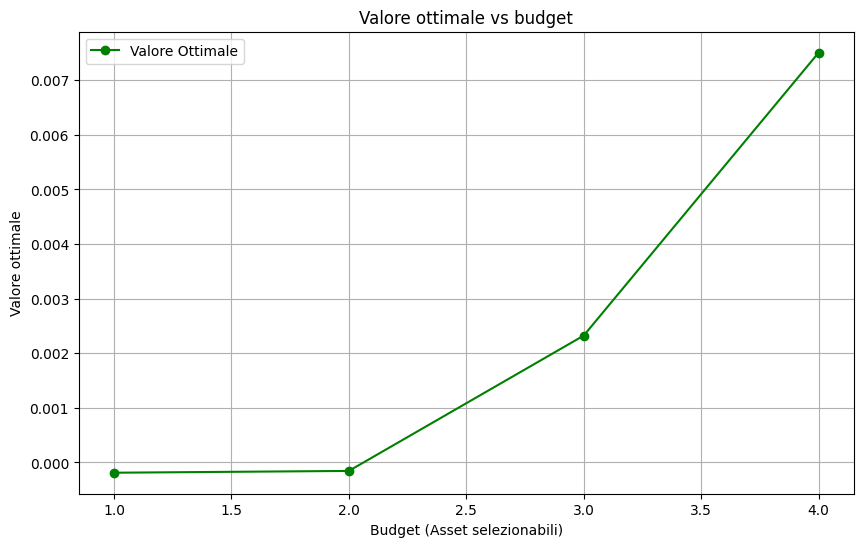

In [53]:
risk = 0.5

budgets = range(1, assets + 1)
values_per_budget = []
selections_per_budget = []

for budget in budgets:
    po = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=risk, budget=budget)
    qp = po.to_quadratic_program()
    
    result = qaoa.solve(qp)
    
    values_per_budget.append(result.fval)
    selections_per_budget.append(result.x)

plt.figure(figsize=(10, 6))
plt.plot(budgets, values_per_budget, marker='o', linestyle='-', color='g', label='Valore Ottimale')
plt.title("Valore ottimale vs budget")
plt.xlabel("Budget (Asset selezionabili)")
plt.ylabel("Valore ottimale")
plt.grid(True)
plt.legend()
plt.show()
